In [1]:
import numpy as np
import pandas as pd
df = pd.read_excel('respuestas_cuestionario.xlsx')

# 1. Codificación correcta: género binario (ignorando "Otro" que no aparece), residencia como one-hot, frecuencia como ordinal
df['genero'] = df['genero'].map({'Hombre': 0, 'Mujer': 1})

# Verificación de valores únicos antes de codificar la frecuencia
actividad_map = {
    'Solo en fiestas o vacaciones': 0,
    'De vez en cuando': 1,
    'Varias veces por semana': 2,
    'A diario': 3
}
df['actividad_frecuencia'] = df['actividad_frecuencia'].map(actividad_map)

# One-hot encoding para residencia (no ordinal)
residencia_dummies = pd.get_dummies(df['residencia'], prefix='residencia')

def expandir_recomendaciones(columna):
    actividades = [
        "Naturaleza y paseos", "Rutas", "Monumentos o historia",
        "Sitios tranquilos para descansar", "Eventos o fiestas",
        "Bares y restaurantes"
    ]
    resultado = pd.DataFrame(0, index=df.index, columns=[f"{columna}_{a}" for a in actividades])
    for i, respuesta in enumerate(df[columna].fillna('')):
        for actividad in actividades:
            if actividad in respuesta:
                resultado.at[i, f"{columna}_{actividad}"] = 1
    return resultado
recom_cols = ['recom_familias', 'recom_jovenes', 'recom_mayores']
recomendaciones_expandidas = pd.concat([expandir_recomendaciones(c) for c in recom_cols], axis=1)
X = pd.concat([
    df[['edad', 'genero', 'actividad_frecuencia', 'freq_recom']],
    residencia_dummies,
    recomendaciones_expandidas
], axis=1)

valoraciones_cols = [col for col in df.columns if col.startswith("valoracion_")]
Y = df[valoraciones_cols].applymap(lambda x: 1 if x >= 4 else 0)

C:\Users\jorge\AppData\Local\Temp\ipykernel_16224\505607549.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y = df[valoraciones_cols].applymap(lambda x: 1 if x >= 4 else 0)


In [2]:
# 1. División de datos
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Entrenar Random Forest (MultiOutput)
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Base estimator con parámetros iniciales
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Multioutput wrapper
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)

# 3. Grid Search de hiperparámetros
param_grid = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [None, 5, 10],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(multi_rf, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

# 4. Evaluación
Y_pred = best_rf.predict(X_test)
print("Reporte de clasificación:\n")
print(classification_report(Y_test, Y_pred, target_names=Y.columns))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores hiperparámetros: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Reporte de clasificación:

                                         precision    recall  f1-score   support

    valoracion_IglesiaSantoDomingoSilos       0.58      0.64      0.61        11
        valoracion_PanteonMarquesesMoya       0.67      0.92      0.77        13
              valoracion_CastilloAliaga       0.25      0.20      0.22         5
                valoracion_LagunaCaolin       0.33      0.20      0.25         5
          valoracion_RiberaRioGuadazaon       0.58      0.85      0.69        13
                valoracion_CerritoArena       0.37      0.78      0.50         9
                 valoracion_MiradorCruz       0.67      1.00      0.80        14
             valoracion_FuenteTresCanos       0.61      0.92      0.73        12
   valoracion_PuenteCris

C:\Users\jorge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


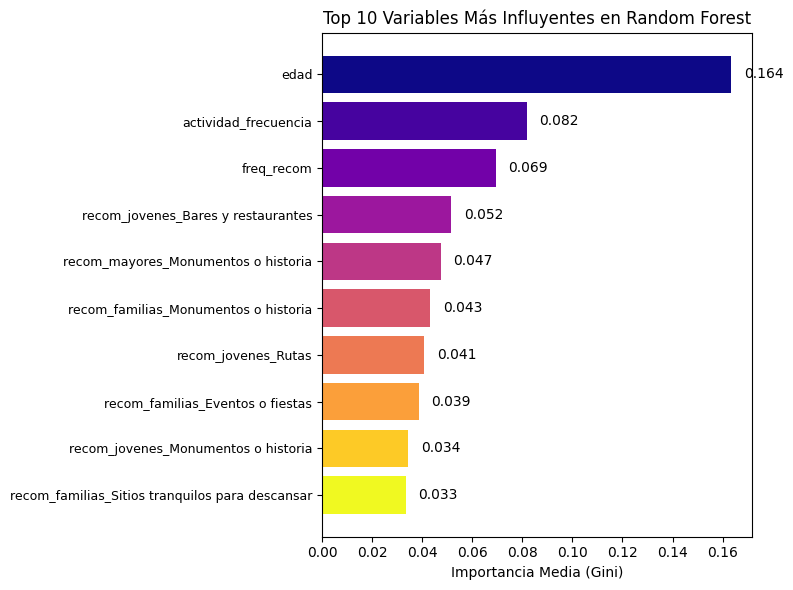

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Entrenar el modelo final con TODOS los datos
best_rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

multi_rf_final = MultiOutputClassifier(best_rf_final, n_jobs=-1)
multi_rf_final.fit(X, Y)

# Calcular la importancia de variables promediando sobre todos los estimadores
importances = np.mean([tree.feature_importances_ for tree in multi_rf_final.estimators_], axis=0)
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Seleccionar el Top 10
top_n = 10
top_features = feature_importance.head(top_n)

# Crear un gráfico atractivo y diferente al estándar
colors = plt.cm.plasma(np.linspace(0, 1, top_n))
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.barh(range(top_n), top_features.values[::-1], color=colors[::-1])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features.index[::-1], fontsize=9)
ax.set_xlabel("Importancia Media (Gini)")
ax.set_title("Top 10 Variables Más Influyentes en Random Forest")

# Etiquetas al final de cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
            f"{width:.3f}", va='center')

plt.tight_layout()
plt.savefig("importancia_variables_RF_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
import joblib

# Guardar el modelo final entrenado
joblib.dump(multi_rf_final, "modelo_turismo.pkl")

['modelo_turismo.pkl']

In [5]:
from sklearn.tree import export_graphviz
import graphviz
import os

# Crear una carpeta para guardar los árboles si no existe
os.makedirs("arboles_decision", exist_ok=True)

# Función para exportar y guardar un árbol
def guardar_arbol(modelo_rf, nombre_salida, feature_names):
    """
    Exporta un árbol individual de un Random Forest como archivo PNG.
    """
    # Seleccionamos el primer árbol del RandomForest para el modelo
    estimator = modelo_rf.estimators_[0]
    
    # Exportar a formato DOT
    dot_file = f"arboles_decision/{nombre_salida}.dot"
    export_graphviz(
        estimator,
        out_file=dot_file,
        feature_names=feature_names,
        class_names=["No Recomienda", "Recomienda"],
        rounded=True,
        filled=True,
        proportion=True,
        precision=2,
        special_characters=True,
        #max_depth=3
    )
    
    # Convertir DOT a PNG usando graphviz
    with open(dot_file) as f:
        dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
    png_path = f"arboles_decision/{nombre_salida}3.png"
    graph.render(filename=png_path, format='png', cleanup=True)
    print(f"Árbol guardado en: {png_path}")

# 1. Árbol para PuenteCristinasRioCabriel
modelo_puente = multi_rf_final.estimators_[Y.columns.get_loc("valoracion_PuenteCristinasRioCabriel")]
guardar_arbol(modelo_puente, "arbol_PuenteCristinasRioCabriel", X.columns)

# 2. Árbol para CastilloAliaga
modelo_castillo = multi_rf_final.estimators_[Y.columns.get_loc("valoracion_CastilloAliaga")]
guardar_arbol(modelo_castillo, "arbol_CastilloAliaga", X.columns)

Árbol guardado en: arboles_decision/arbol_PuenteCristinasRioCabriel3.png
Árbol guardado en: arboles_decision/arbol_CastilloAliaga3.png
